In [26]:
import tensorflow as tf
from pathlib import Path
import tensorflow_datasets as tfds
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

### importing data

In [32]:
train_data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_data_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test"
path = Path(train_data_dir)
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
num_images= 50

In [30]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

![](http://)### Preprocessing

In [33]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

valid_generator = valid_datagen.flow_from_directory(
    test_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 11230 images belonging to 6 classes.
Found 598 images belonging to 6 classes.


In [34]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
num_train_samples = len(train_generator.filenames)  
num_valid_samples = len(valid_generator.filenames)

### Model Building

Using an existing model, Inception V3 is a convolutional neural network (CNN) that was developed by Google in 2016. It was trained on the ImageNet dataset, which contains over 1.2 million images labeled with 1000 different object categories. It is also a popular choice for transfer learning, which is a technique for using a pre-trained model as a starting point for training a new model on a different task.

In [36]:
inception_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, channels),
    pooling=None,
    classifier_activation="softmax",
)

In [38]:
model = Sequential()

# set each layer in the pretrained model to untrainable
for layer in inception_model.layers:
    layer.trainable= False
    
model.add(inception_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### validation

In [40]:
history = model.fit(
    train_generator, 
    epochs = 10,
    steps_per_epoch = num_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = num_valid_samples//batch_size,
    shuffle = True
)

Epoch 1/10
175/175 [==============================] - 213s 1s/step - loss: 0.2121 - accuracy: 0.7683 - val_loss: 0.1276 - val_accuracy: 0.8646
Epoch 2/10
175/175 [==============================] - 152s 866ms/step - loss: 0.1368 - accuracy: 0.8569 - val_loss: 0.1087 - val_accuracy: 0.8924
Epoch 3/10
175/175 [==============================] - 148s 846ms/step - loss: 0.1271 - accuracy: 0.8660 - val_loss: 0.1026 - val_accuracy: 0.8941
Epoch 4/10
175/175 [==============================] - 151s 861ms/step - loss: 0.1194 - accuracy: 0.8730 - val_loss: 0.1028 - val_accuracy: 0.8889
Epoch 5/10
175/175 [==============================] - 153s 872ms/step - loss: 0.1148 - accuracy: 0.8764 - val_loss: 0.0961 - val_accuracy: 0.9045
Epoch 6/10
175/175 [==============================] - 151s 863ms/step - loss: 0.1150 - accuracy: 0.8757 - val_loss: 0.0933 - val_accuracy: 0.8993
Epoch 7/10
175/175 [==============================] - 152s 868ms/step - loss: 0.1141 - accuracy: 0.8753 - val_loss: 0.0935 - va

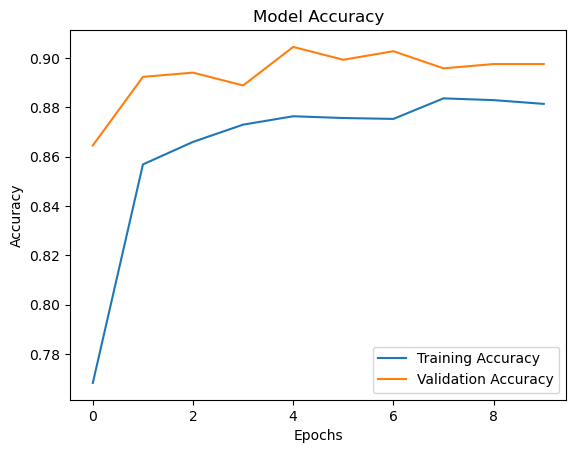

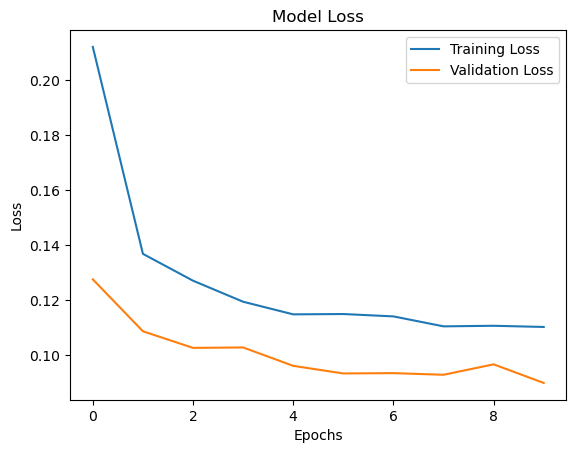

In [41]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

model.save('intel_image_model.hdf5')